# ARIMA with Python

Se puede crear un modelo ARIMA utilizando la biblioteca statsmodels de la siguiente manera:

* Defina el modelo llamando a ARIMA () y pasando los parámetros p, d y q.
* El modelo se prepara en los datos de entrenamiento llamando a la función de ajuste ().
Las predicciones se pueden hacer llamando a la función de predicción () y especificando el índice del tiempo o los tiempos a predecir.
* Vamos a empezar con algo simple. Ajustaremos un modelo ARIMA a todo el conjunto de datos de Shampoo Sales y revisaremos los errores residuales.

Primero, ajustamos un modelo ARIMA (5,1,0). Esto establece el valor de retraso en 5 para la autorregresión, utiliza un orden de diferencia de 1 para hacer que la serie de tiempo sea estacionaria y utiliza un modelo de media móvil de 0.

Al ajustar el modelo, se proporciona una gran cantidad de información de depuración sobre el ajuste del modelo de regresión lineal. Podemos desactivar esto estableciendo el argumento disp en 0.

In [7]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


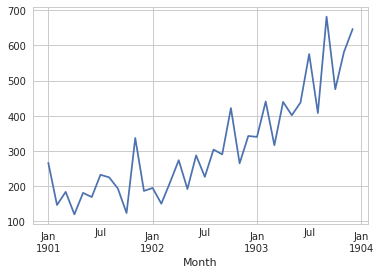

In [8]:
def parser_x(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, 
                  squeeze=True, date_parser=parser_x)
print(series.head())
series.plot()

Siguiendo el ejemplo, podemos ver que hay una correlación positiva con los primeros 10 a 12 rezagos que quizás sea significativa para los primeros 5 rezagos.<br>
Un buen punto de partida para el parámetro AR del modelo puede ser 5.

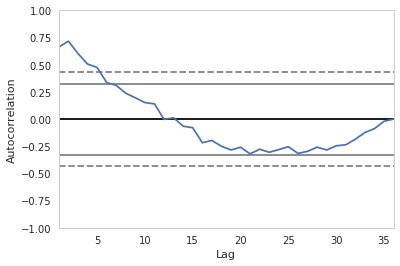

In [10]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

In [11]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
print(dir(model_fit))

/home/rmg/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/rmg/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Thu, 31 Jan 2019   AIC                            406.340
Time:                                                 11:57:50   BIC                            417.227
Sample:                                             02-01-1901   HQIC                           410.098
                                                  - 12-01-1903                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

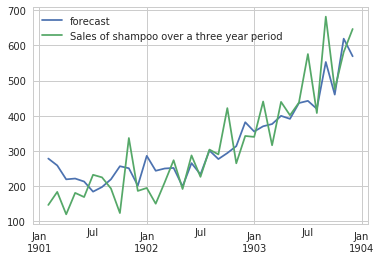

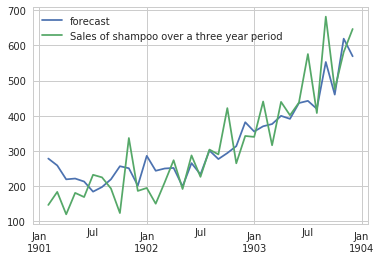

In [16]:
model_fit.plot_predict()

In [24]:
model_fit.forecast()

(array([564.21353606]),
 array([64.24141928]),
 array([[438.30266796, 690.12440416]]))

Primero, obtenemos una gráfica de líneas de los errores residuales, lo que sugiere que aún puede haber alguna información de tendencias que no haya sido capturada por el modelo.

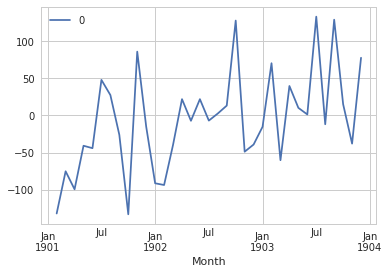

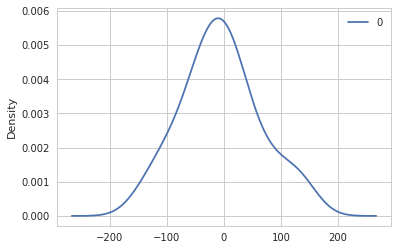

In [20]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

In [23]:
residuals.describe().T

,count,mean,std,min,25%,50%,75%,max
0,35.0,-5.495218,68.132882,-133.296637,-42.47789,-7.186512,24.74833,133.237936


Tenga en cuenta que, aunque anteriormente usamos el conjunto de datos completo para el análisis de series de tiempo, lo ideal sería realizar este análisis solo en el conjunto de datos de entrenamiento al desarrollar un modelo predictivo.

A continuación, veamos cómo podemos usar el modelo ARIMA para hacer pronósticos.

# Modelo ARIMA Rolling Forecast

El modelo ARIMA se puede utilizar para pronosticar pasos de tiempo futuros.

Podemos usar la función predecir () en el objeto ARIMAResults para hacer predicciones. Acepta el índice de los pasos de tiempo para hacer predicciones como argumentos. Estos índices son relativos al inicio del conjunto de datos de entrenamiento utilizado para hacer predicciones.

Si utilizamos 100 observaciones en el conjunto de datos de entrenamiento para ajustar el modelo, entonces el índice del siguiente paso de tiempo para hacer una predicción se especificará a la función de predicción como inicio = 101, final = 101. Esto devolvería una matriz con un elemento que contiene la predicción.

También preferiríamos que los valores pronosticados estén en la escala original, en caso de que realicemos alguna diferencia (d> 0 al configurar el modelo). Esto puede especificarse estableciendo el argumento de tipo al valor ‘niveles’: tipo = ’niveles’.

Alternativamente, podemos evitar todas estas especificaciones utilizando la función forecast (), que realiza un pronóstico de un solo paso utilizando el modelo.

Podemos dividir el conjunto de datos de entrenamiento en conjuntos de pruebas y trenes, usar el conjunto de trenes para ajustar el modelo y generar una predicción para cada elemento en el conjunto de pruebas.

Se requiere un pronóstico continuo dada la dependencia de las observaciones en pasos de tiempo anteriores para la diferenciación y el modelo AR. Una forma burda de realizar este pronóstico continuo es recrear el modelo ARIMA después de recibir cada nueva observación.

Realizamos un seguimiento manual de todas las observaciones en una lista llamada historial que está sembrada con los datos de entrenamiento ya los que se agregan nuevas observaciones en cada iteración.

Poniendo todo esto junto, a continuación se muestra un ejemplo de un pronóstico continuo con el modelo ARIMA en Python.

In [26]:
type(series)

pandas.core.series.Series

In [ ]:
from sklearn.metrics import mean_squared_error
 
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()